In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import urllib.request
import json
import re
from sklearn import metrics

In [43]:
# load and clean zip code dataset (zip, gnn, and latitude longitude )
working_directory = os.getcwd()
df_county = pd.read_excel(working_directory + '/Residential Facilities with County.xlsx')

# do this to keep the larger county
df_county = df_county.sort_values(['ZIP CODE','NUMBER OF FACILITIES'])
df_county = df_county[~df_county['ZIP CODE'].duplicated(keep='first')]

In [47]:
# load and clean zip code dataset (zip, gnn, and latitude longitude )
working_directory = os.getcwd()
df = pd.read_excel(working_directory + '/Residential Facilities.xlsx')

print('Dropping ' + str(df.isnull().values.any(axis=1).sum()) + ' zip codes out of ' + str(df.shape[0]) + ' because of nan values')
df.dropna(axis = 0, inplace=True)
print(df.shape)
df['LOG_COUNT'] = np.log10(df['COUNT'])

df = df.join(df_county[['ZIP CODE','COUNTY']].set_index('ZIP CODE'), on = 'ZIP_CD')
print(df.shape)

Dropping 2 zip codes out of 648 because of nan values
(646, 4)
(646, 6)


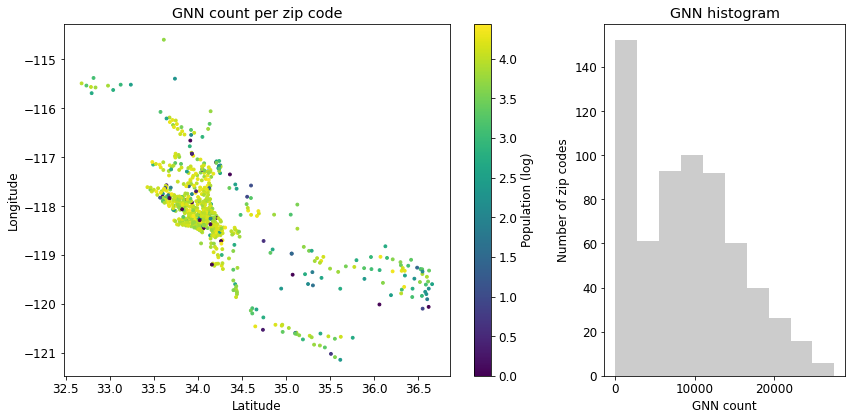

In [49]:
# EDA of dataset
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 12})

gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
plt.subplot(gs[0])
plt.scatter(df['Median Latitude'],df['Median Longitude'], c = df['LOG_COUNT'], s=8)
cb = plt.colorbar()
cb.ax.set_ylabel('Population (log)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('GNN count per zip code')

plt.subplot(gs[1])
plt.hist(df['COUNT'], color= [.8, .8, .8])
plt.xlabel('GNN count')
plt.ylabel('Number of zip codes')
plt.title('GNN histogram')

# one gnn could be multiple meters
plt.tight_layout()
plt.show()


# Build distance matrix request and run Google Maps API 

In [ ]:
# chunk destination zip codes since google's api can't handle that >100 requests per ping
def chunk_it(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out


In [ ]:
# since we cannot throw the whole 640x640 request into google maps API, we break it down by origin start 
myfile = open(r'C:\Users\jacheung\Dropbox\API Keys\maps_API.txt')
API_key = myfile.read()

# build zip list for google api request 
# note that commas are replaced with %2C
df['API lat long'] = df['Median Latitude'].astype(str) + '%2C' + df['Median Longitude'].astype(str)
zip_list = "|".join(df['API lat long'].to_list())
zip_list = zip_list.split('|')

#chunking zip codes

num_destination_chunks = 8 
destination_chunks = chunk_it(zip_list,num_destination_chunks)

chunk_lengths = [len(chunks) for chunks in destination_chunks]
accumulator = 0 
distances = [0]

for k in chunk_lengths:
    accumulator += k
    distances.append(accumulator)    


# build empty matrices for distance and duration 
duration_matrix = np.zeros([len(zip_list), len(zip_list)])
distance_matrix = np.zeros([len(zip_list), len(zip_list)])

# build request components 
foundation = 'https://maps.googleapis.com/maps/api/distancematrix/json?'
units = 'units=imperial'
API = 'key=' + API_key

for origin_index, points in enumerate(zip_list):
    origins = 'origins=' + points
    print(origin_index)
    for destination_index, destination in enumerate(destination_chunks):
        destination_string = "|".join(destination)
        destination = 'destinations=' + destination_string

        # build request
        request = foundation + units + '&' + origins + '&' + destination + '&' + API

        # ping Maps API
        res = urllib.request.urlopen(request).read()
        data = json.loads(res.decode())

        # populate matrices
        for origin in data['rows']:
            duration_value = []
            distance_value = []
            for destination_loop in origin['elements']:
                duration_value.append(re.sub("[^0-9]", "", destination_loop['duration']['text']))
                distance_value.append(re.sub("[^0-9]", "", destination_loop['distance']['text']))

        duration_matrix[origin_index, distances[destination_index]:distances[destination_index+1]] = duration_value
        distance_matrix[origin_index, distances[destination_index]:distances[destination_index+1]] = distance_value

        
#save files
duration_df = pd.DataFrame(duration_matrix)
duration_df.columns = df['ZIP_CD']
duration_df.index = df['ZIP_CD']
duration_df.to_csv(working_directory + '/duration_dataframe.csv')

distance_df = pd.DataFrame(distance_matrix)
distance_df.columns = df['ZIP_CD']
distance_df.index = df['ZIP_CD']
distance_df.to_csv(working_directory + '/distance_dataframe.csv')

# Load distance/duration matrix built from Google Maps API

In [ ]:
# create pseudo distance matrix
from scipy.spatial import distance_matrix
all_coordinates = np.array(df[['Median Latitude', 'Median Longitude']])

distance_matrix = distance_matrix(all_coordinates,all_coordinates)

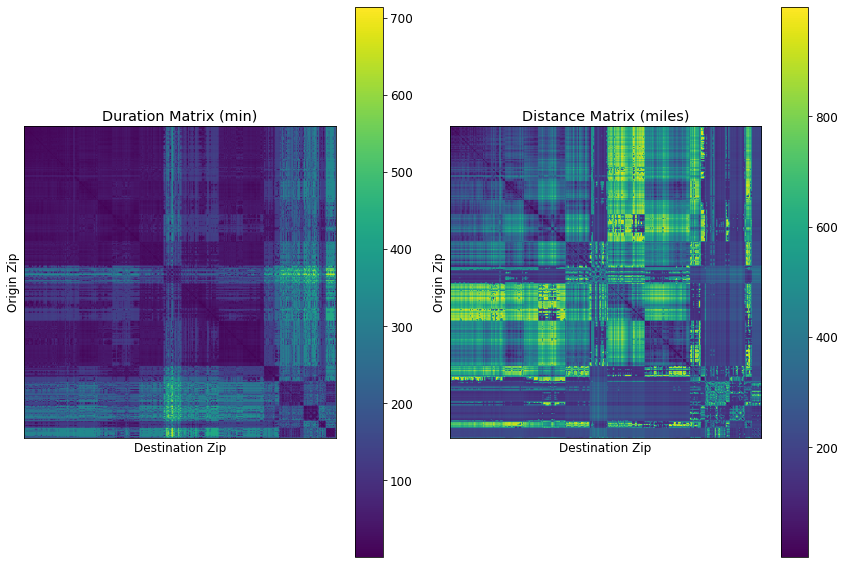

In [50]:
# load distance and duration matrices 
duration_df = pd.read_csv(working_directory + '/duration_dataframe.csv')
duration_df = duration_df.set_index('ZIP_CD').to_numpy()

distance_df = pd.read_csv(working_directory + '/distance_dataframe.csv')
distance_df = distance_df.set_index('ZIP_CD').to_numpy()

# view matrix
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(duration_df)
plt.xticks([]), plt.yticks([])
plt.ylabel('Origin Zip'), plt.xlabel('Destination Zip')
plt.title('Duration Matrix (min)')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(distance_df)
plt.xticks([]), plt.yticks([])
plt.ylabel('Origin Zip'), plt.xlabel('Destination Zip')
plt.title('Distance Matrix (miles)')
plt.colorbar()

plt.tight_layout()
plt.show()

In [94]:
county_counts = df.groupby('COUNTY').agg({'COUNT':'sum'}).reset_index()
county_counts.sort_values('COUNT')

,COUNTY,COUNT
3,KINGS,12393
8,SAN DIEGO,15021
0,FRESNO,36107
1,IMPERIAL - ALL OTHERS,52963
2,KERN,126088
9,SAN LUIS OBISPO,139123
10,SANTA BARBARA,149582
11,TULARE,179879
12,VENTURA,299644
7,SAN BERNARDINO,462771


In [97]:
# single clusters 
singles = np.array(county_counts[county_counts['COUNT']<200000]['COUNTY'])

doubles = np.array(county_counts[(county_counts['COUNT']>=200000) & (county_counts['COUNT']<=500000)]['COUNTY'])
for k in doubles:
    zips = df[df['COUNTY'] == k]['ZIP_CD']
    x = distance_df['ZIP_CD'].isin(zips)
    y = distance_df.columns.isin(zips.astype(str))
    county_distance_df = distance_df.loc[x,y]
    clusters = AgglomerativeClustering(n_clusters=2).fit(county_distance_df)


array(['SAN BERNARDINO', 'VENTURA'], dtype=object)

In [165]:
distance_df = pd.read_csv(working_directory + '/distance_dataframe.csv')
distance_df = distance_df.set_index('ZIP_CD')

zips = df[df['COUNTY'] == 'SAN BERNARDINO']['ZIP_CD']
x = distance_df.index.isin(zips)
y = distance_df.columns.isin(zips.astype(str))
county_distance_df = distance_df.loc[x,y]
clusters = AgglomerativeClustering(n_clusters=3).fit(county_distance_df)
max_add = df['labels'].max()
df[df['ZIP_CD'].isin(zips)]['labels'] = clusters.labels_ + max_add

<ipython-input-165-ed7647b7cf94>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df['ZIP_CD'].isin(zips)]['labels'] = clusters.labels_ + max_add


In [167]:
df[df['ZIP_CD'].isin(zips)]

,ZIP_CD,COUNT,Median Latitude,Median Longitude,LOG_COUNT,COUNTY,labels
104,90382.0,1,34.205661,-117.104724,0.000000,SAN BERNARDINO,8
241,91701.0,12422,34.130734,-117.598923,4.094192,SAN BERNARDINO,6
244,91708.0,4628,33.961863,-117.622765,3.665393,SAN BERNARDINO,6
246,91710.0,22431,34.018177,-117.686107,4.350849,SAN BERNARDINO,6
247,91711.0,11350,34.111823,-117.720408,4.054996,SAN BERNARDINO,6
251,91730.0,22646,34.109780,-117.583446,4.354992,SAN BERNARDINO,6
255,91737.0,7968,34.141640,-117.579800,3.901349,SAN BERNARDINO,6
256,91739.0,12420,34.125696,-117.526916,4.094122,SAN BERNARDINO,6
269,91762.0,18333,34.055535,-117.664909,4.263234,SAN BERNARDINO,6
270,91763.0,9858,34.070432,-117.699571,3.993789,SAN BERNARDINO,6


In [127]:
distance_df.columns 

Index(['ZIP_CD', '90001.0', '90002.0', '90003.0', '90004.0', '90005.0',
       '90006.0', '90007.0', '90008.0', '90010.0',
       ...
       '93654.0', '93656.0', '93660.0', '93662.0', '93666.0', '93670.0',
       '93673.0', '93706.0', '93722.0', '93725.0'],
      dtype='object', length=647)

# See ceiling of clustering via Agglomerative Clustering

Ceiling for clustering using matrix is 5.348348052654221


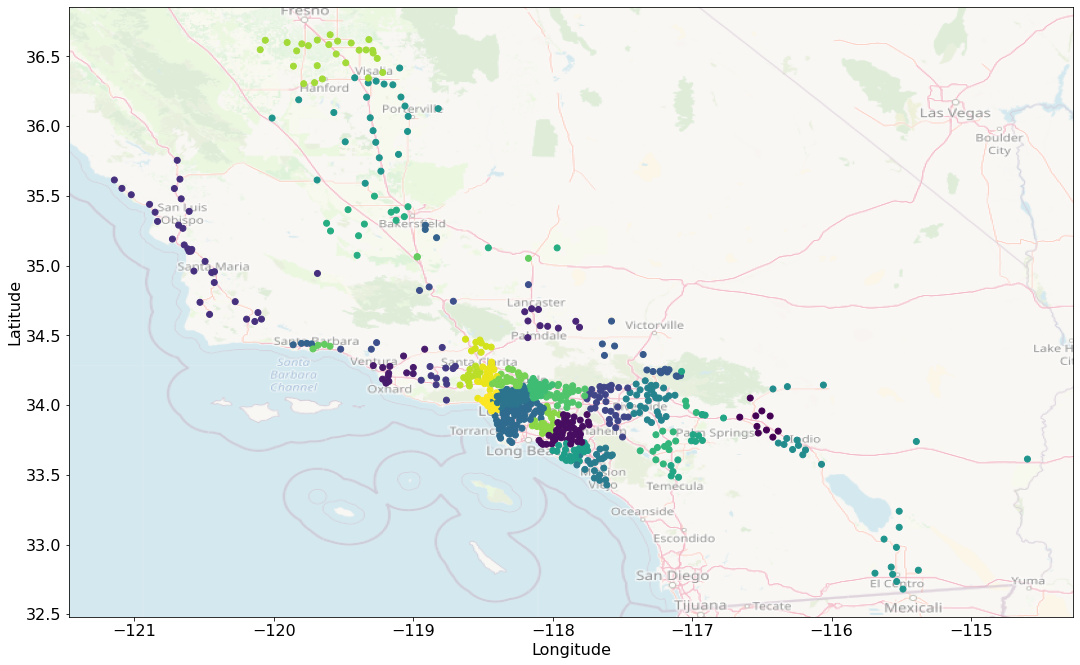

In [67]:
from sklearn.cluster import KMeans, AgglomerativeClustering
# agglomerative clustering is a type of hierachiccal clustering. It's a low-level clustering meaning that all points start
# as their own clusters. Using the matrix it then computes closest neighbors and adds to the group. 

X = df[['COUNT','Median Latitude', 'Median Longitude']]

clusters = AgglomerativeClustering(n_clusters=30).fit(distance_df)
# clusters = KMeans(n_clusters=30).fit(X)
# KPI_metric = metrics.silhouette_score(X, clusters.labels_, metric='euclidean')
KPI_metric = metrics.calinski_harabasz_score(X, clusters.labels_)
df['labels'] = clusters.labels_

# plotting backgrounds
background = plt.imread(working_directory + '/map_overlay.png')
BBox = ((-121.47144956736001,   -114.26796652984,      
         32.481483034369994, 36.85481607823))

plt.figure(figsize = (18,16))
plt.rcParams.update({'font.size': 16})

plt.scatter(df['Median Longitude'], df['Median Latitude'], zorder=1, c = clusters.labels_)
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(background, zorder=0, extent = BBox, alpha = .5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.savefig('./products/cluster_with_map_overlay.png')
print('Ceiling for clustering using matrix is ' + str(KPI_metric))

,COUNT
COUNTY,
FRESNO,36107
IMPERIAL - ALL OTHERS,52963
KERN,126088
KINGS,12393
LOS ANGELES,2677623
ORANGE,931829
RIVERSIDE,698808
SAN BERNARDINO,462771
SAN DIEGO,15021


In [58]:
def span(series):
    return series.max() - series.min()

In [83]:
summary_raw = X.groupby('labels').agg({'COUNT':'sum',
                        'Median Longitude': span,
                        'Median Latitude': span})

summary_raw.loc[:,'Median Longitude'] = summary_raw.loc[:,'Median Longitude'] * 54.6
summary_raw.loc[:,'Median Latitude'] = summary_raw.loc[:,'Median Latitude'] * 69
summary_raw.rename(columns = {'Median Longitude' : 'Longitude span (miles)',
                             'Median Latitude' : 'Latitude span (miles)',
                             'COUNT': 'Customer total'}, inplace=True)
summary_raw.describe().to_csv('./products/cluster_summary.csv')

In [92]:
df[['ZIP_CD','labels']].to_csv('./products/zip_with_labels.csv')

,COUNT,Median Longitude,Median Latitude
count,30.000000,30.000000,30.000000
mean,192727.833333,36.289558,32.956916
std,144883.127645,54.709765,45.484612
min,22589.000000,6.137002,6.446335
25%,93897.250000,13.417648,14.615611
50%,155540.000000,18.005505,20.140881
75%,241893.750000,28.439900,30.674929
max,584926.000000,295.773366,257.869265


# Seed run and find global min

In [6]:
# params
cluster_num = 30
iterations = 10000
max_capacity = df['COUNT'].sum()/cluster_num
buffer = max_capacity*.25 #5% buffer person buffer past max_capacity 
matrix_to_use = distance_df

# final outputs
KPI_solid = -1
index_solid = np.zeros([cluster_num, df.shape[0]])


for iteration in np.arange(0,iterations):
    # randomize centroid index 
    centroid_idx = np.random.choice(np.arange(0,df.shape[0]),cluster_num, replace=False)
    centroid_accumulator = np.array(df.iloc[centroid_idx,1])
    index_accumulator = np.zeros([cluster_num,df.shape[0]])
    index_accumulator[np.arange(0, cluster_num),centroid_idx] = 1
    
    # for loop that pairs a destination to closest seed using distance matrix
    points_to_pair = np.nonzero(~np.in1d(np.arange(0, df.shape[0]), centroid_idx))[0]
    for loop_idx in points_to_pair:
        sorted_distance_idx = np.argsort(matrix_to_use[loop_idx,centroid_idx])

        # accumulate population and loop_idx
        for idx in sorted_distance_idx:
            if centroid_accumulator[idx] < max_capacity + buffer:
                np.add.at(index_accumulator[idx,:],loop_idx,1)
                centroid_accumulator[idx] += df.iloc[loop_idx,1]
                break

    # KPIs for clustering: see here https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
    label,idx = np.nonzero(index_accumulator)
    labels = label[np.argsort(idx)]
    X = df[['Median Latitude', 'Median Longitude']]
    KPI_metric = metrics.silhouette_score(X, labels, metric='euclidean')
#     KPI_metric = metrics.calinski_harabasz_score(X, labels)
                             
    if KPI_metric > KPI_solid:
        print('Progress made on iteration ' + str(iteration+1))
        print('Silhouette score :' + str(KPI_metric))
        KPI_solid = KPI_metric
        index_solid = index_accumulator

Progress made on iteration 1
Silhouette score :-0.25543408639954557
Progress made on iteration 4
Silhouette score :-0.23513979194976165
Progress made on iteration 6
Silhouette score :-0.22675253592470423
Progress made on iteration 7
Silhouette score :-0.17608323636647466
Progress made on iteration 25
Silhouette score :-0.17317388153386376
Progress made on iteration 30
Silhouette score :-0.1577721998860011
Progress made on iteration 59
Silhouette score :-0.15568565029529394
Progress made on iteration 153
Silhouette score :-0.1393324033918654
Progress made on iteration 169
Silhouette score :-0.13325487446854603
Progress made on iteration 216
Silhouette score :-0.11460854770742356
Progress made on iteration 1673
Silhouette score :-0.10649440592056579
Progress made on iteration 8064
Silhouette score :-0.10124532089544304


# Simulated Annealing

# Plot clusters

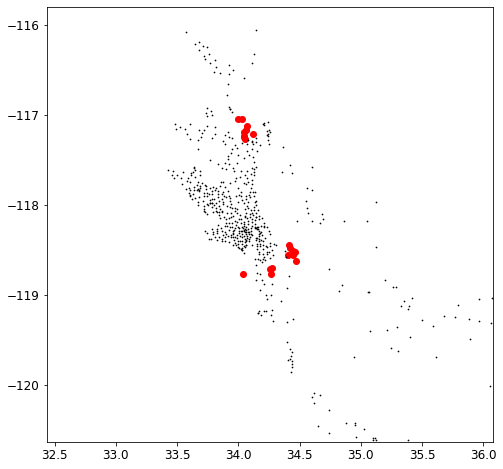

In [23]:
group_balance = []
x_mean,y_mean = df[['Median Latitude','Median Longitude']].mean()
x_sd,y_sd = df[['Median Latitude','Median Longitude']].std()

def plot_random_cluster(seed):
    fig = plt.figure(figsize=(8,8))
    plt.rcParams.update({'font.size': 12})
    points = np.nonzero(index_solid[seed,:])
    not_points = np.nonzero(index_solid[seed,:]==0)
    plot_df = df.iloc[points]
    gray_df = df.iloc[not_points]

    plt.scatter(plot_df['Median Latitude'], plot_df['Median Longitude'],c='r')
    plt.scatter(gray_df['Median Latitude'], gray_df['Median Longitude'],c='k', s = .5)
    plt.xlim(x_mean-2.5*x_sd, x_mean+2.5*x_sd)
    plt.ylim(y_mean-2.5*y_sd, y_mean+2.5*y_sd)
    plt.show()
    
    
plot_random_cluster(np.random.choice(np.arange(0,index_solid.shape[0])))

(array([ 1.,  1.,  0.,  1.,  6.,  2.,  2.,  2.,  1., 14.]),
 array([ 31724.,  53874.,  76024.,  98174., 120324., 142474., 164624.,
        186774., 208924., 231074., 253224.]),
 <a list of 10 Patch objects>)

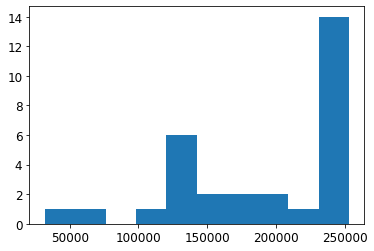

In [19]:
label,idx = np.nonzero(index_solid)
labels = label[np.argsort(idx)]
df['Cluster'] = labels
plt.hist(df.groupby('Cluster').aggregate('sum').reset_index()['COUNT'])